### Idea

Input state and data -> train against tomorrow state.

After training, generate full matrix for tomorrow by inputting all states.

Is apparently useful for inference and further finacial analysis.

It is thus time dependent.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [2]:
# Load your processed data
train_df = pd.read_csv("dataset/train.csv")
labels_df = pd.read_csv("dataset/labels.csv")

print(train_df.shape, labels_df.shape)
train_df.head()

(4181, 134) (4181, 1)


,index,Price,Percent_change_backward,Backward_Bin,CVol,Change,% Change,% Return,Total Return (Gross),Cumulative Return %,...,Assets under Supervision,Assets under Management,Assets under Administration,# of Branches,Change in Branches,Average Assets - Total,Efficiency Ratio,Opinion,HY_bond_rate,IG_bond_rate
0,1,41.99,0.840538,36,81687750.0,0.35,0.84,0.84,57.94,11.86,...,15979000,1153000,14826000,5423,2266,1756359,76.0,NaN,14.80,7.93
1,2,40.71,-3.048345,10,95310305.0,-1.28,-3.05,-3.05,56.17,8.45,...,15979000,1153000,14826000,5423,2266,1756359,76.0,NaN,15.04,8.00
2,3,38.49,-5.453206,6,84755610.0,-2.22,-5.45,-5.45,53.11,2.54,...,15979000,1153000,14826000,5423,2266,1756359,76.0,NaN,15.60,7.89
3,4,40.49,5.196155,50,75112400.0,2.00,5.20,5.20,55.87,7.87,...,15979000,1153000,14826000,5423,2266,1756359,76.0,NaN,15.79,8.07
4,5,39.33,-2.864905,11,60995870.0,-1.16,-2.86,-2.86,54.27,4.78,...,15979000,1153000,14826000,5423,2266,1756359,76.0,NaN,16.35,8.36


In [3]:
# ============================================
# DATA PREPARATION
# ============================================

print("Original shape:", train_df.shape)

# 1. Drop Opinion column (contains NaN)
train_df = train_df.drop(columns=["Opinion"], errors="ignore")
print("After dropping Opinion:", train_df.shape)

# 2. Create Percent_change_forward if it doesn't exist
if "Percent_change_forward" not in train_df.columns:
    train_df["Percent_change_forward"] = (
        train_df["Price"].shift(-1) / train_df["Price"] - 1
    ) * 100.0
    print("✓ Created Percent_change_forward column")

# 3. Drop the last row (has NaN for forward return)
train_df = train_df.iloc[:-1].copy()
labels_df = labels_df.iloc[:-1].copy()

print("Final shape:", train_df.shape)
print("✓ Data ready for training")



Original shape: (4181, 134)
After dropping Opinion: (4181, 133)
✓ Created Percent_change_forward column
Final shape: (4180, 134)
✓ Data ready for training


In [4]:
drop_cols = ["index", "Percent_change_forward", "Backward_Bin"]
feature_cols = [c for c in train_df.columns if c not in drop_cols]

X_all = train_df[feature_cols].values.astype(np.float32)

# States: make them 0-based for PyTorch
s_curr_all = (train_df["Backward_Bin"].values.astype(np.int64) - 1)
y_all      = (labels_df["Forward_Bin"].values.astype(np.int64) - 1)

n_samples, n_features = X_all.shape
n_states = int(max(s_curr_all.max(), y_all.max()) + 1)

print("n_samples:", n_samples)
print("n_features:", n_features)
print("n_states:", n_states)


n_samples: 4180
n_features: 131
n_states: 55


In [5]:
# Create the Percent_change_forward column if it doesn't exist
if "Percent_change_forward" not in train_df.columns:
    train_df["Percent_change_forward"] = (
        train_df["Price"].shift(-1) / train_df["Price"] - 1
    ) * 100.0
    print("Created Percent_change_forward column")
else:
    print("Percent_change_forward already exists")

Percent_change_forward already exists


In [6]:
# Temporal split: 70 / 15 / 15
T = n_samples
train_end = int(0.7 * T)
val_end   = int(0.85 * T)

idx_train = np.arange(0,        train_end)
idx_val   = np.arange(train_end, val_end)
idx_test  = np.arange(val_end,  T)

def split(arr):
    return arr[idx_train], arr[idx_val], arr[idx_test]

X_train, X_val, X_test = split(X_all)
s_train, s_val, s_test = split(s_curr_all)
y_train, y_val, y_test = split(y_all)

# Standardize features based on *training* only
mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8

X_train_std = (X_train - mean) / std
X_val_std   = (X_val   - mean) / std
X_test_std  = (X_test  - mean) / std

# Store for later (transition matrices on full data)
X_all_std = (X_all - mean) / std


In [7]:
class TransitionDataset(Dataset):
    def __init__(self, X, s_curr, s_next):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.s_curr = torch.tensor(s_curr, dtype=torch.long)
        self.s_next = torch.tensor(s_next, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.s_curr[idx], self.s_next[idx]

train_ds = TransitionDataset(X_train_std, s_train, y_train)
val_ds   = TransitionDataset(X_val_std,   s_val,   y_val)
test_ds  = TransitionDataset(X_test_std,  s_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False)


In [8]:
class TransitionNet(nn.Module):
    def __init__(self, n_features, n_states, hidden_dims=(64,128, 256, 128, 64), dropout=0.2):
        super().__init__()
        self.n_states = n_states

        layers = []
        in_dim = n_features + n_states  # features + one-hot state

        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            in_dim = h

        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(in_dim, n_states)

    def forward(self, x, s_curr):
        """
        x:      (B, n_features)
        s_curr: (B,)  int state indices in [0, n_states-1]
        """
        s_onehot = F.one_hot(s_curr, num_classes=self.n_states).float()
        z = torch.cat([x, s_onehot], dim=-1)
        h = self.mlp(z)
        logits = self.out(h)
        return logits


In [9]:
device = DEVICE

model = TransitionNet(n_features=n_features, n_states=n_states).to(device)

# Class weights: inverse frequency of next-state bins
class_counts = np.bincount(y_train, minlength=n_states)
class_weights = class_counts.sum() / np.maximum(class_counts, 1)
class_weights = class_weights / class_weights.mean()  # rescale a bit
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights_t)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [10]:
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_n = 0
    total_correct = 0

    with torch.set_grad_enabled(train):
        for X_batch, s_curr_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            s_curr_batch = s_curr_batch.to(device)
            y_batch = y_batch.to(device)

            if train:
                optimizer.zero_grad()

            logits = model(X_batch, s_curr_batch)
            loss = criterion(logits, y_batch)

            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            total_n    += batch_size

            preds = logits.argmax(dim=1)
            total_correct += (preds == y_batch).sum().item()

    return total_loss / total_n, total_correct / total_n

n_epochs = 40

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc = run_epoch(train_loader, train=True)
    val_loss,   val_acc   = run_epoch(val_loader,   train=False)

    print(
        f"Epoch {epoch:03d} | "
        f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.3f}"
    )

test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"Test loss {test_loss:.4f}, test acc {test_acc:.3f}")


Epoch 001 | train loss 4.0105 acc 0.019 | val loss 4.0218 acc 0.026
Epoch 002 | train loss 4.0100 acc 0.019 | val loss 4.0218 acc 0.026
Epoch 003 | train loss 4.0097 acc 0.019 | val loss 4.0215 acc 0.026
Epoch 004 | train loss 4.0095 acc 0.015 | val loss 4.0214 acc 0.021
Epoch 005 | train loss 4.0092 acc 0.022 | val loss 4.0211 acc 0.021
Epoch 006 | train loss 4.0078 acc 0.017 | val loss 4.0207 acc 0.019
Epoch 007 | train loss 4.0077 acc 0.015 | val loss 4.0204 acc 0.021
Epoch 008 | train loss 4.0057 acc 0.016 | val loss 4.0199 acc 0.021
Epoch 009 | train loss 4.0019 acc 0.016 | val loss 4.0191 acc 0.026
Epoch 010 | train loss 3.9969 acc 0.016 | val loss 4.0178 acc 0.026
Epoch 011 | train loss 3.9822 acc 0.017 | val loss 4.0157 acc 0.026
Epoch 012 | train loss 3.9647 acc 0.016 | val loss 4.0124 acc 0.026
Epoch 013 | train loss 3.9379 acc 0.018 | val loss 4.0077 acc 0.026
Epoch 014 | train loss 3.9199 acc 0.024 | val loss 4.0018 acc 0.026
Epoch 015 | train loss 3.8999 acc 0.020 | val lo

In [11]:
def build_transition_matrix_for_day(k):
    """
    k: integer index in [0, n_samples-1] (row in your CSV)
    returns: A_k of shape (n_states, n_states)
    """
    model.eval()
    x_k = torch.tensor(X_all_std[k], dtype=torch.float32, device=device)

    # Repeat the same features for each possible current state i
    x_rep = x_k.unsqueeze(0).repeat(n_states, 1)  # (n_states, n_features)
    s_curr_all = torch.arange(n_states, dtype=torch.long, device=device)

    with torch.no_grad():
        logits = model(x_rep, s_curr_all)         # (n_states, n_states)
        A_k = F.softmax(logits, dim=1)            # probabilities

    return A_k.cpu()  # (n_states, n_states)


In [12]:
k_example = 100  # pick a date by row index
A_k = build_transition_matrix_for_day(k_example)

print(A_k.shape)     # should be (n_states, n_states)
print(A_k.sum(dim=1))  # each row ~ 1.0


torch.Size([55, 55])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


In [13]:
# Build model-based transition matrices A_all for all k
# A_all[k] has shape (n_states, n_states)

model.eval()

A_all_list = []

with torch.no_grad():
    for k in range(n_samples):
        A_k = build_transition_matrix_for_day(k)   # (n_states, n_states)
        A_all_list.append(A_k.unsqueeze(0))        # (1, n_states, n_states)

A_all = torch.cat(A_all_list, dim=0)               # (n_samples, n_states, n_states)
print(A_all.shape)


torch.Size([4180, 55, 55])


In [14]:
import os

os.makedirs("transition_outputs", exist_ok=True)

# Save transition matrices
torch.save(A_all, "transition_outputs/A_all_model.pt")
np.save("transition_outputs/A_all_model.npy", A_all.numpy())

# Save model weights for comprehensive analysis
torch.save(model.state_dict(), "transition_outputs/model_weights.pt")

print("Saved A_all and model weights to transition_outputs/")

Saved A_all and model weights to transition_outputs/


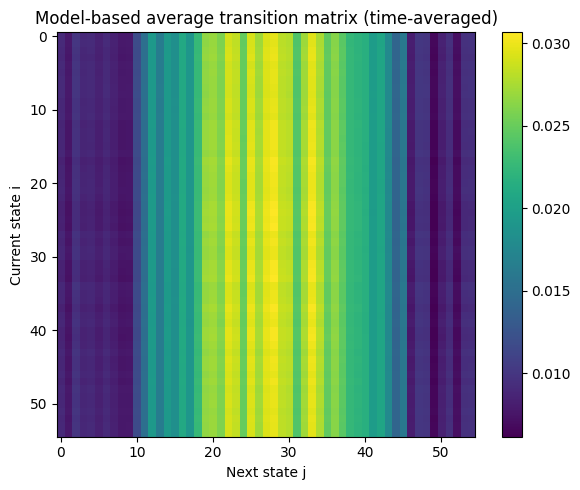

In [15]:
import matplotlib.pyplot as plt

# Average over time (k dimension)
A_mean = A_all.mean(dim=0).numpy()   # (n_states, n_states)

plt.figure(figsize=(6, 5))
im = plt.imshow(A_mean, aspect='auto')
plt.colorbar(im)
plt.xlabel("Next state j")
plt.ylabel("Current state i")
plt.title("Model-based average transition matrix (time-averaged)")
plt.tight_layout()
plt.show()


Empirical transition matrix shape: (55, 55)


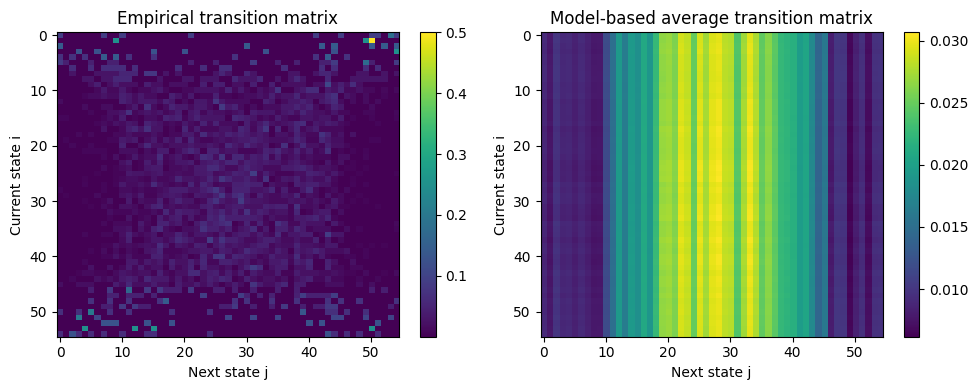

In [16]:
# You already have these:
# s_curr_all = Backward_Bin - 1
# y_all = Forward_Bin - 1
# n_states = max bin + 1

A_emp_counts = np.zeros((n_states, n_states), dtype=np.float64)

# Build counts
for i, j in zip(s_curr_all, y_all):
    A_emp_counts[i, j] += 1

# Convert to probabilities with smoothing to avoid zero-rows
A_emp = (A_emp_counts + 1e-8) / (A_emp_counts.sum(axis=1, keepdims=True) + 1e-8)

print("Empirical transition matrix shape:", A_emp.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(A_emp, aspect='auto')
axes[0].set_title("Empirical transition matrix")
axes[0].set_xlabel("Next state j")
axes[0].set_ylabel("Current state i")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(A_mean, aspect='auto')
axes[1].set_title("Model-based average transition matrix")
axes[1].set_xlabel("Next state j")
axes[1].set_ylabel("Current state i")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


Number of states: 55
bin_midpoints length: 55
First few bin_midpoints (%): [-14.0251369   -9.43763665  -8.32352872  -7.44376635  -6.52116321
  -5.46272864  -4.77816139  -4.23742897  -3.70901018  -3.23916288]
Simulated price array shape: (10, 11)


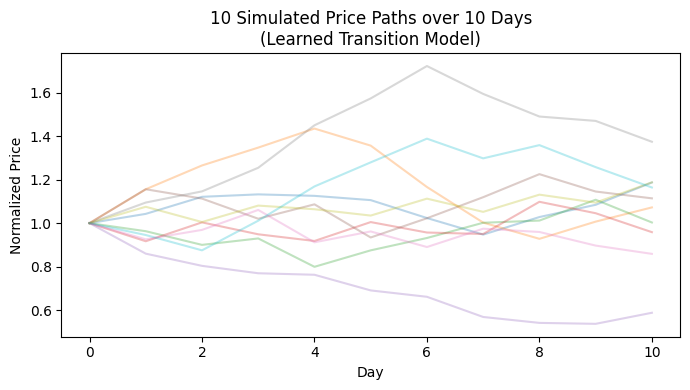

In [17]:
# ---------------------------------------------------------
# 0. BUILD BIN MIDPOINTS FROM DATA (NO GUESSING)
# ---------------------------------------------------------
# We define one representative return per state j as the
# mean of Percent_change_forward over all samples with Forward_Bin = j+1.

# Make sure these exist from earlier in the notebook:
# - train_df: DataFrame with column "Percent_change_forward"
# - labels_df: DataFrame with column "Forward_Bin"
# - y_all: 0-based next-state labels (Forward_Bin - 1)
# - n_states: number of unique states

returns_pct_all = train_df["Percent_change_forward"].values.astype(float)

# Sanity: shapes should match
assert len(returns_pct_all) == len(y_all), "returns and labels length mismatch"

bin_midpoints = np.zeros(n_states, dtype=float)

for s in range(n_states):
    mask = (y_all == s)
    if mask.any():
        bin_midpoints[s] = returns_pct_all[mask].mean()
    else:
        # if a state never occurs as a next-state, fallback to 0% return
        bin_midpoints[s] = 0.0

print("Number of states:", n_states)
print("bin_midpoints length:", len(bin_midpoints))
print("First few bin_midpoints (%):", bin_midpoints[:10])


# ---------------------------------------------------------
# 1. SIMULATION FUNCTION
# ---------------------------------------------------------
def simulate_price_path(start_k, horizon, A_all_tensor, s_curr_all, bin_midpoints, start_state=None):
    """
    Simulates a single price path of length `horizon`, using learned daily
    transition matrices A_all and empirical bin_midpoints for returns.
    
    start_k:       starting time index (int)
    horizon:       number of days to simulate (int)
    A_all_tensor:  (T, n_states, n_states), torch tensor or np array
    s_curr_all:    array of current-state labels (0-based) length T
    bin_midpoints: array length n_states, mean forward return for each state (percent)
    start_state:   optional initial state; if None, uses s_curr_all[start_k]
    
    Returns:
      states: np.array of shape (<= horizon+1,)
      rets:   np.array of daily returns (decimal)
      prices: np.array of normalized prices
    """
    # Convert to numpy if it's a tensor
    if hasattr(A_all_tensor, "detach"):
        A_all_np = A_all_tensor.detach().cpu().numpy()
    else:
        A_all_np = np.asarray(A_all_tensor)

    n_samples, n_states_, _ = A_all_np.shape
    assert n_states_ == len(bin_midpoints), "A_all and bin_midpoints state dimension mismatch"

    k = start_k
    if start_state is None:
        current_state = int(s_curr_all[k])
    else:
        current_state = int(start_state)

    states = [current_state]
    rets = []
    prices = [1.0]   # start at normalized price 1.0

    for _ in range(horizon):
        if k >= n_samples:
            break

        # transition probabilities for current state at day k
        P = A_all_np[k, current_state]
        P = P / P.sum()  # safety normalize

        next_state = np.random.choice(np.arange(n_states_), p=P)

        # map state → return percentage → decimal return
        r_pct = bin_midpoints[next_state]      # e.g. +0.3 (%)
        r = r_pct / 100.0                      # decimal

        new_price = prices[-1] * (1.0 + r)

        states.append(next_state)
        rets.append(r)
        prices.append(new_price)

        current_state = next_state
        k += 1

    return np.array(states), np.array(rets), np.array(prices)


# ---------------------------------------------------------
# 2. SIMULATE 100 PATHS × 100 DAYS
# ---------------------------------------------------------
num_paths = 10
horizon = 10
start_k = 0  # starting day index; you can change this

all_prices = []

for i in range(num_paths):
    states, rets, prices = simulate_price_path(
        start_k=start_k,
        horizon=horizon,
        A_all_tensor=A_all,
        s_curr_all=s_curr_all,
        bin_midpoints=bin_midpoints,
        start_state=None  # use actual state at start_k
    )
    all_prices.append(prices)

all_prices = np.array(all_prices, dtype=float)

print("Simulated price array shape:", all_prices.shape)  # (num_paths, <= horizon+1)


# ---------------------------------------------------------
# 3. PLOT THE 100×100 SIMULATIONS
# ---------------------------------------------------------
plt.figure(figsize=(7, 4))
for path in all_prices:
    plt.plot(path, alpha=0.3)
plt.title(f"10 Simulated Price Paths over {horizon} Days\n(Learned Transition Model)")
plt.xlabel("Day")
plt.ylabel("Normalized Price")
plt.tight_layout()
plt.show()


In [18]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix

# =====================================================
# 0. EVALUATE TRANSITION MODEL ON TEST SET
# =====================================================
# Assumes you already have: model, run_epoch, test_loader
model_test_loss, model_test_acc = run_epoch(test_loader, train=False)
print(f"[Transition model] test loss = {model_test_loss:.4f}, acc = {model_test_acc:.4f}")


# =====================================================
# 1. BASELINE MODEL (features → next state)
#    Uses SAME loaders & splits for fair comparison
# =====================================================
class BaselineNet(nn.Module):
    def __init__(self, n_features, n_states):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, n_states)
        )
    def forward(self, x, s_curr_ignored=None):
        # ignore current state
        return self.net(x)

baseline = BaselineNet(n_features, n_states).to(device)
optimizer_b = torch.optim.Adam(baseline.parameters(), lr=1e-3)
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion_b = nn.CrossEntropyLoss(weight=class_weights_t)



# =====================================================
# 2. TRAINING LOOP FOR BASELINE
#    Reuses existing loaders: (X_batch, s_curr_batch, y_batch)
# =====================================================
def run_epoch_baseline(loader, train=False):
    if train:
        baseline.train()
    else:
        baseline.eval()

    total_loss, total_correct, total_n = 0.0, 0, 0

    with torch.set_grad_enabled(train):
        for Xb, s_currb, yb in loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            logits = baseline(Xb)  # ignore s_currb
            loss = criterion_b(logits, yb)

            if train:
                optimizer_b.zero_grad()
                loss.backward()
                optimizer_b.step()

            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_loss += loss.item() * len(Xb)
            total_n += len(Xb)

    return total_loss / total_n, total_correct / total_n


# =====================================================
# 3. TRAIN BASELINE (WITH VAL-BASED CHECKPOINT)
# =====================================================
best_val = float("inf")
best_state = None

for epoch in range(1, 16):
    tr_loss, tr_acc = run_epoch_baseline(train_loader, train=True)
    va_loss, va_acc = run_epoch_baseline(val_loader,   train=False)

    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.cpu().clone() for k, v in baseline.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(f"[Baseline] Epoch {epoch:02d} | "
              f"train {tr_loss:.3f}/{tr_acc:.3f} | "
              f"val {va_loss:.3f}/{va_acc:.3f}")

baseline.load_state_dict(best_state)
baseline.to(device)


# =====================================================
# 4. TEST EVAL FOR BASELINE
# =====================================================
baseline_test_loss, baseline_test_acc = run_epoch_baseline(test_loader, train=False)

print("\n==== FINAL COMPARISON ====")
print(f"Transition model | loss = {model_test_loss:.4f}, acc = {model_test_acc:.4f}")
print(f"Baseline model   | loss = {baseline_test_loss:.4f}, acc = {baseline_test_acc:.4f}")


# =====================================================
# 5. OPTIONAL: CONFUSION MATRIX FOR BASELINE
# =====================================================
baseline.eval()
all_true, all_pred = [], []

with torch.no_grad():
    for Xb, s_currb, yb in test_loader:
        Xb = Xb.to(device)
        logits = baseline(Xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_pred.append(preds)
        all_true.append(yb.numpy())

all_true = np.concatenate(all_true)
all_pred = np.concatenate(all_pred)

cm_baseline = confusion_matrix(all_true, all_pred, labels=np.arange(n_states))
print(cm_baseline.shape)  # should now be (55, 55)


[Transition model] test loss = 4.1123, acc = 0.0526
[Baseline] Epoch 01 | train 3.999/0.013 | val 4.049/0.022
[Baseline] Epoch 05 | train 3.598/0.047 | val 4.282/0.029
[Baseline] Epoch 10 | train 3.423/0.062 | val 4.427/0.030
[Baseline] Epoch 15 | train 3.328/0.065 | val 4.533/0.029

==== FINAL COMPARISON ====
Transition model | loss = 4.1123, acc = 0.0526
Baseline model   | loss = 4.1409, acc = 0.0351
(55, 55)
